In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent
from models.experiment_designs.experiment1 import gen_task_param


In [2]:
n_sims = 150

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = 0.0
alpha_scale = 1.0

inv_temp = 2.5
goal_prior = 10e-20 
prunning_threshold = 10.0
evaluate = True

np.random.seed(11223344)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None'):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):
        alpha = list_alpha[ii]
        
        agent = AgentClass(
            Experiment(*task_args, **task_kwargs), 
            alpha=alpha, inv_temp=inv_temp, 
            goal_prior=goal_prior)
        
        _res = agent.generate(evaluate=evaluate, prunning_threshold=prunning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [3]:
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(JointClusteringAgent, name='Flat')
results = pd.concat([results_ic, results_jc, results_fl])

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

## Model Predictions
Summary Statistics:

In [4]:
results['Training'] = results.Context < 5
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  Goal KL Divergence  In Goal  Key-press  \
Training Model                                                           
False    Flat         6.166667            1.757069     True   3.488667   
         Independent  6.166667            1.789722     True   3.489111   
         Joint        6.166667            1.799074     True   3.515556   
True     Flat         2.750000            0.552214     True   3.502111   
         Independent  2.750000            0.538826     True   3.503278   
         Joint        2.750000            0.578291     True   3.501667   

                      Map KL Divergence  Steps Taken  Times Seen Context  \
Training Model                                                             
False    Flat                  0.422038     8.267556            4.666667   
         Independent           0.217166     7.645333            4.666667   
         Joint                 0.404355     8.238667            4.666667   
True     Flat                  0.185302     7.260444           16.333333   
         Independent           0.162138     7.241222           16.333333   
         Joint                 0.203704    12.156556           16.333333   

                      Trial Number  Iteration       Acc  
Training Model                                           
False    Flat                134.5       74.5  0.828444  
         Independent         134.5       74.5  0.805333  
         Joint               134.5       74.5  0.822889  
True     Flat                 59.5       74.5  0.941722  
         Independent          59.5       74.5  0.916167  
         Joint                59.5       74.5  0.941667

Plot the overall rewards collected in the training and test contexts

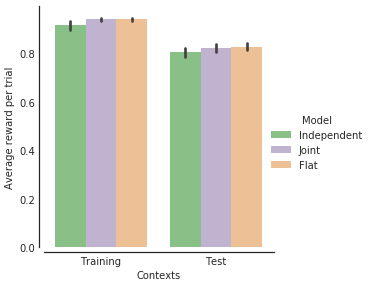

In [5]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 5, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 5, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

Break down the accuracy in each test context

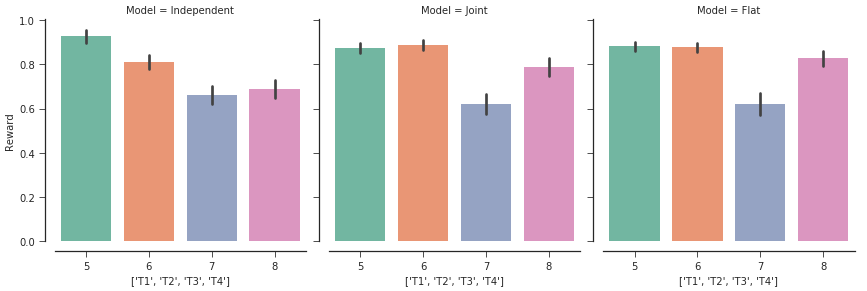

In [19]:
with sns.axes_style('ticks'):
    g = sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Set2', col='Model', units='Iteration')
    g.set_xlabels(['T1', 'T2', 'T3', 'T4'])
    sns.despine(offset=10)
    

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

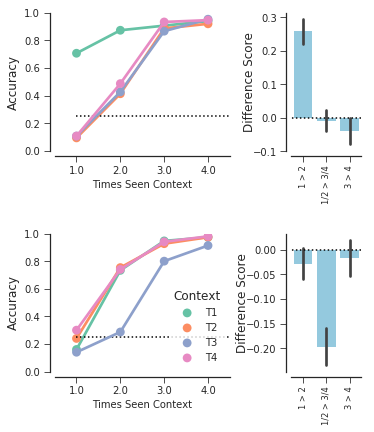

In [13]:
from matplotlib import gridspec

# plot the difference scores
df0 = results[results['In Goal'] & (results.Context > 4) & (results['Times Seen Context'] <= 4) &
              (results['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 6, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 5) & 
              (results['Times Seen Context'] < 5) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 6.6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [
        [plt.subplot(gs[0]), plt.subplot(gs[1])],
        [plt.subplot(gs[2]),  plt.subplot(gs[3])]
    ]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=axes[0][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=axes[1][0])
    
    axes[0][0].legend_.remove() 
    ax = axes[1][0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Independent'], color='skyblue', ax=axes[0][1])
    sns.barplot(x='Comparison', y='Difference Score', #units='Iteration',
            data=score[score.Model == 'Joint'], color='skyblue', ax=axes[1][1])
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
        ax.plot([0, 5], [0.25, 0.25], 'k:')
        ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    for ii in [0, 1]:
        ax = axes[ii][1]
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        plt.sca(ax)
        plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'3 > 4' ], rotation='vertical',
                  fontsize='small')
    

# Meta Agent 

In [8]:
from models.agents import MetaAgent
results_meta = sim_agent(MetaAgent, name='Meta')
results_wMeta = pd.concat([results, results_meta])
results_wMeta['Acc'] = pd.to_numeric(results_wMeta.Reward)

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

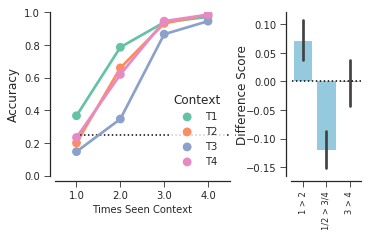

In [14]:
from matplotlib import gridspec

# plot the difference scores
df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context > 4) & 
                    (results_wMeta['Times Seen Context'] <= 4) &
                    (results_wMeta['Model'] != 'Flat')
                   ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 6, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
            


score = pd.concat(score) 

df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context >= 5) &
                   (results_wMeta['Times Seen Context'] < 5)].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [ plt.subplot(gs[0]), plt.subplot(gs[1])]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Meta'],  palette='Set2', ax=axes[0])
    
    ax = axes[0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Meta'], color='skyblue', ax=axes[1])
    
    ax = axes[0]
    ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    ax = axes[1]
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    plt.sca(ax)
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'3 > 4' ], rotation='vertical',
              fontsize='small')
    

Plot the evolution of the model responsibilities over time

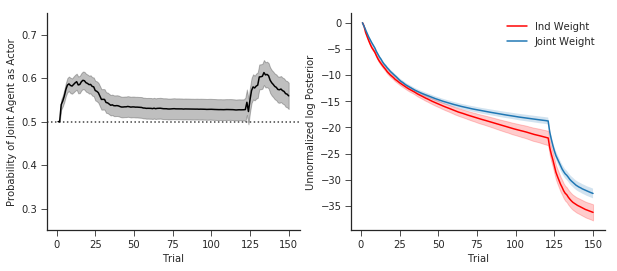

In [53]:
from matplotlib.ticker import NullFormatter


with sns.axes_style('ticks'):

    df0 = results_wMeta[(results_wMeta['Steps Taken']==1) & 
                  (results_wMeta['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.25, 0.75])

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()

In [11]:
results_wMeta.to_pickle('Experiment1sim.pkl')